In [ ]:
import numpy as np
from typing import List, Optional, Dict, Set, Callable, Any, Literal
from joblib import Memory, Parallel, delayed
import torch
from torch import Tensor

from experiments.cross_validation import cv_UEA, print_cv_results
from experiments.eval_on_test import validate_UEA, print_test_results
from experiments.utils import join_dicts_from_pickle_paths, save_to_pickle, print_latex_results, load_dataset
from experiments.experiment_code import run_all_kernels

# Cross Validation on Train

In [ ]:
cv_results = cv_UEA(
    dataset_names = [
        # 'CharacterTrajectories',       # N_corpus = 71, N_train = 1400 ish
        # 'Epilepsy',                    # N_corpus = 34
        # 'EthanolConcentration',        # N_corpus = 65
        # 'FingerMovements',             # N_corpus = 158
        # 'HandMovementDirection',       # N_corpus = 40
        # 'Heartbeat',                   # N_corpus = 102
        # 'LSST',                        # N_corpus = 176, N_train = 3000 ish
        # 'MotorImagery',                # N_corpus = 139
        # 'PEMS-SF',                     # N_corpus = 38
        # 'PhonemeSpectra',              # N_corpus = 85, N_train = 3000 ish
        'RacketSports',                # N_corpus = 38
        # 'SelfRegulationSCP1',          # N_corpus = 134
        # 'SelfRegulationSCP2',          # N_corpus = 100
        ],
    kernel_names = [
            "flat linear",
            # "flat rbf",
            # "flat poly",
            # "integral rbf",
            # "integral poly",
            "trunc sig linear",
            # "trunc sig rbf",
            # "pde sig rbf",
            "rand sig tanh",
            # "gak",
            # "reservoir",
        ],
        k_folds=5,
        n_repeats=1,
        verbose=False,
        omit_alpha=True,
        )

# Validate on Test

In [ ]:
test_results = validate_UEA(cv_results, verbose=False, device="cuda")
print_test_results(test_results)

In [ ]:
print(test_results)
print_test_results(test_results)

# Validate on Test and Save

In [ ]:
for dataset_name, cv_res in cv_results.items():
    test_results = validate_UEA({dataset_name : cv_res}, verbose=True, device="cuda")
    save_to_pickle(test_results, f"Data/results_{dataset_name}.pkl")

# Read CV data from file and print results

In [ ]:
# Load the cross validation results
cv_results = join_dicts_from_pickle_paths(
    [
    "Data/cv_CharacterTrajectories.pkl",
    "Data/cv_Epilepsy.pkl",
    "Data/cv_EthanolConcentration.pkl",
    "Data/cv_FingerMovements.pkl",
    "Data/cv_HandMovementDirection.pkl",
    "Data/cv_Heartbeat.pkl",
    "Data/cv_LSST.pkl",
    "Data/cv_MotorImagery.pkl",
    "Data/cv_PEMS-SF.pkl",
    "Data/cv_PhonemeSpectra.pkl",
    "Data/cv_RacketSports.pkl",
    "Data/cv_SelfRegulationSCP1.pkl",
    "Data/cv_SelfRegulationSCP2.pkl",
    ])
print_cv_results(cv_results)

In [ ]:
test_results = join_dicts_from_pickle_paths([
    "Data/results_CharacterTrajectories.pkl",
    "Data/results_Epilepsy.pkl",
    "Data/results_EthanolConcentration.pkl",
    "Data/results_FingerMovements.pkl",
    "Data/results_HandMovementDirection.pkl",
    "Data/results_Heartbeat.pkl",
    "Data/results_LSST.pkl",
    "Data/results_MotorImagery.pkl",
    "Data/results_PEMS-SF.pkl",
    "Data/results_PhonemeSpectra.pkl",
    "Data/results_RacketSports.pkl",
    "Data/results_SelfRegulationSCP1.pkl",
    "Data/results_SelfRegulationSCP2.pkl",
                                             ])
print_latex_results(test_results, round_digits=2)

# Print distribution of CV params

In [4]:
import matplotlib.pyplot as plt

all_datasets = [
    "CharacterTrajectories",
    "Epilepsy",
    "EthanolConcentration",
    "FingerMovements",
    "HandMovementDirection",
    "Heartbeat",
    "LSST",
    "MotorImagery",
    "PEMS-SF",
    "PhonemeSpectra",
    "RacketSports",
    "SelfRegulationSCP1",
    "SelfRegulationSCP2",
    ]

all_kernels = [
    "flat linear",
    "flat rbf",
    "flat poly",
    "integral rbf",
    "integral poly",
    "rand sig tanh",
    "trunc sig linear",
    "trunc sig rbf",
    "pde sig rbf",
    "gak",
    "reservoir",
    ]


def plot_cv_params_single_kernel(
        cv_results:Dict,
        param_name:str = "sigma", 
        kernel_name:str = "flat rbf", 
        datasets:Optional[List[str]] = None, 
        n_bins:int = 30,
    ):
    """
    For each dataset, plot the histogram of the best parameter
    values specified by 'param_name' for the kerenl "kernel_name".
    """
    if datasets is None:
        datasets = list(cv_results.keys())

    l = []
    for dataset_name, results in cv_results.items():
        if dataset_name in datasets:
            for anomaly_method in ["conf_results", "mahal_results"]:
                kernelwise_dict = results[anomaly_method]
                for ker, labelwise_dict in kernelwise_dict.items():
                    for label, param_dict in labelwise_dict.items():
                        if ker == kernel_name:
                            l.append(param_dict[param_name])
    l = np.array(l)
    l.sort()
    l = l.astype(str)

    plt.hist(l, n_bins)
    plt.xlabel(param_name)
    plt.ylabel("Frequency")
    plt.title(f"Kernel: {kernel_name}")
    plt.xticks(rotation='vertical')
    plt.show()



def plot_cv_params_all_kernels(
        cv_results:Dict,
        param_name:str = "sigma",
        kernels:Optional[List[str]] = None, 
        datasets:Optional[List[str]] = None,
        n_bins:int = 30,
    ):
    """
    For each dataset, plot the histogram of the best parameter
    values specified by 'param_name' for all the kernels.
    """
    if datasets is None:
        datasets = list(cv_results.keys())
    if kernels is None:
        kernels = list(cv_results[datasets[0]]["conf_results"].keys())

    l = []
    for dataset_name, results in cv_results.items():
        if dataset_name in datasets:
            for anomaly_method in ["conf_results", "mahal_results"]:
                kernelwise_dict = results[anomaly_method]
                for kernel_name, labelwise_dict in kernelwise_dict.items():
                    if kernel_name in kernels:
                        for label, param_dict in labelwise_dict.items():
                            if kernel_name == kernel_name:
                                if param_name in param_dict:
                                    l.append(param_dict[param_name])
    l = np.array(l)
    l.sort()
    l = l.astype(str)

    plt.hist(l, n_bins)
    plt.xlabel(param_name)
    plt.ylabel("Frequency")
    plt.title(f"All datasets: {param_name}")
    plt.xticks(rotation='vertical')
    plt.show()

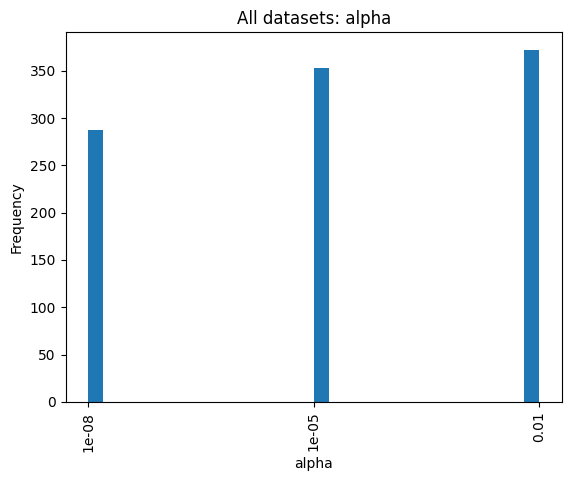

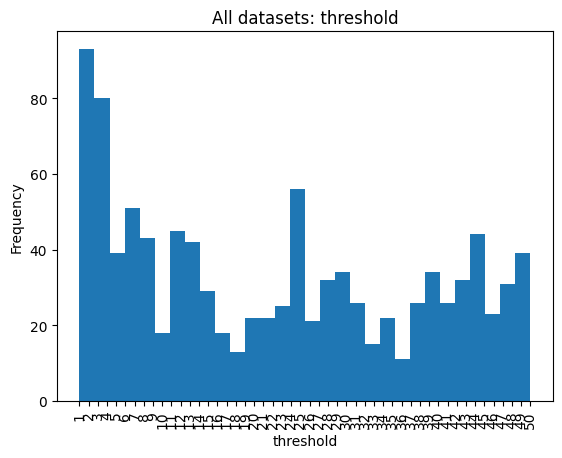

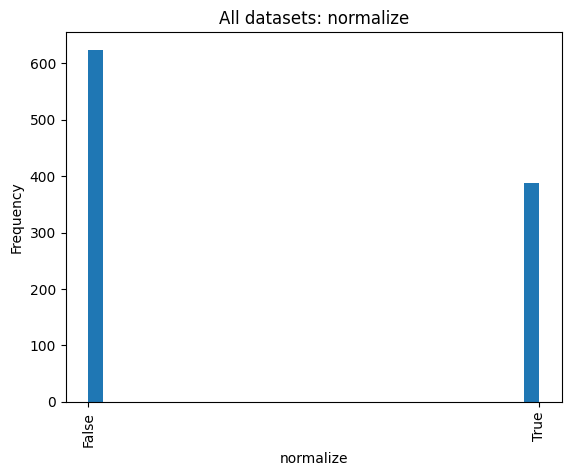

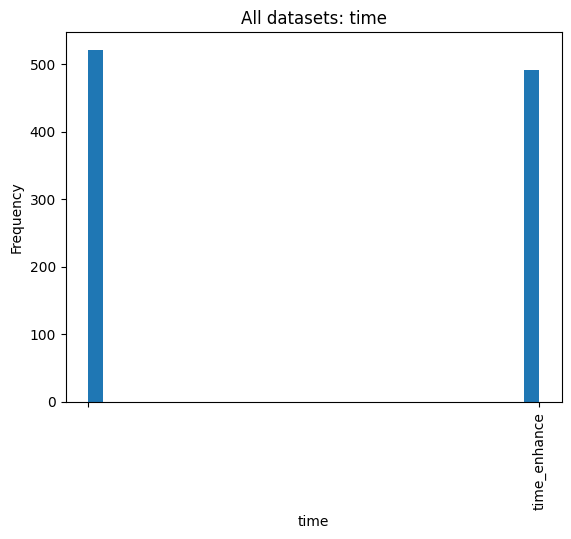

In [5]:
plot_cv_params_all_kernels(cv_results, "alpha")
plot_cv_params_all_kernels(cv_results, "threshold")
plot_cv_params_all_kernels(cv_results, "normalize")
plot_cv_params_all_kernels(cv_results, "time")

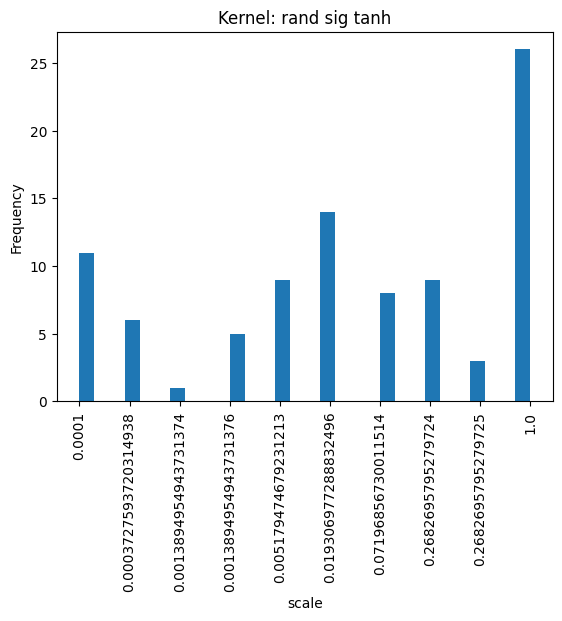

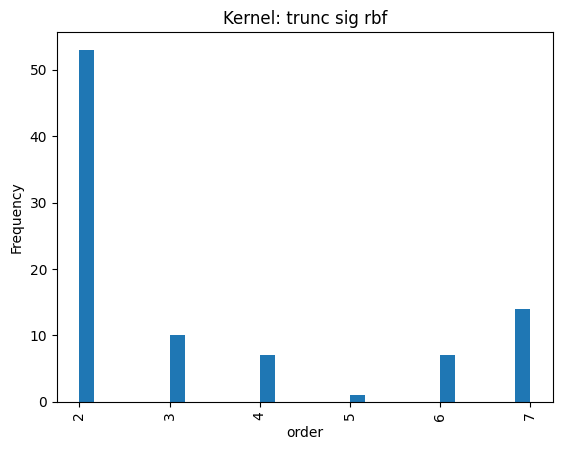

In [10]:
plot_cv_params_single_kernel(cv_results, "scale", "rand sig tanh")
plot_cv_params_single_kernel(cv_results, "order", "trunc sig rbf")

# Run specific param_dict on specific dataset

In [ ]:
import torch
from typing import Dict
from experiments.experiment_code import run_all_kernels
from experiments.utils import load_dataset
import numpy as np
def run_specific_param_dict(
        dataset_name:str, 
        param_dict:Dict,
        verbose:bool = False,
        device="cuda",
    ):    
    """Runs the specific param_dict on a dataset.
    
    Args:
        dataset_name (str): Name of the dataset.
        param_dict (Dict): Dictionary of parameters.
        verbose (bool): Verbosity.
        device (str): Device for PyTorch computation.
        """
    X_train, y_train, X_test, y_test = load_dataset(dataset_name)
    X_train = torch.from_numpy(X_train).to(device)
    X_test = torch.from_numpy(X_test).to(device)
    unique_labels = np.unique(y_train)
    kernel_name = param_dict["kernel_name"]

    #create kernelwise dict
    kernelwise_dict = {kernel_name: {label: param_dict for label in unique_labels}}

    results = run_all_kernels(X_train, y_train, X_test, y_test, 
                        unique_labels, kernelwise_dict, verbose)
    aucs = results[kernel_name]
    print("Conf ROCAUC\t", aucs[0,0])
    print("Conf PRAUC\t", aucs[0,1])
    print("Mah ROCAUC\t", aucs[1,0])
    print("Mah PRAUC\t", aucs[1,1])
    return results


# General Parameters
param_dict = {
    "alpha": 0.0001,
    "threshold": 70,
    "normalize": False,
    "time": "",
    "basepoint": "basepoint",
}


# Kernel Specific Parameters
param_dict["kernel_name"] = "pde sig rbf"
param_dict["order"] = 3
param_dict["sigma"] = 10
param_dict["scale"] = 1
param_dict["gak_factor"] = 10
param_dict["dyadic_order"] = 2
param_dict["gamma"] = 0.999
param_dict["tau"] = 1/5.5/np.sqrt(10)

res = run_specific_param_dict("CharacterTrajectories", param_dict, verbose=True)

In [ ]:
np.exp(np.linspace(-9.2, 1.6, 8))

In [ ]:
np.geomspace(0.0001, 1, 8)